# Содержание

>[Содержание](#scrollTo=G7U4HGmiKmw-)

>[Домашнее задание](#scrollTo=1YAUbI9mlU-_)

>>[1 Подключение необходимых библиотек](#scrollTo=xjyB7PM6lhdH)

>>[2 Загрузка датасета](#scrollTo=GT0l7wXRDbnG)

>>[3 Определение тренировочного и валидационного датафрейма](#scrollTo=wEkm8EHWDk_z)

>>[4 Обзор целевой переменной](#scrollTo=dnkdKy-UQE5b)

>>[5 Перевод текста в нижний регистр](#scrollTo=kyyEdgC3DkNB)

>>[6 Определение классов Dataset и Model](#scrollTo=3GpGeJr3SzDy)

>>>[6.1 Определение имени модели](#scrollTo=0wLu6Nv5WumQ)

>>[7 Запись данных в собственый класс(Dataset) и в Dataloader](#scrollTo=bUe8PHzrW4OV)

>>[8 Определение модели, функции потерь и оптимизатора](#scrollTo=2AVMYgMfXOLF)

>>[9 Обучение модели](#scrollTo=yeR3KC1DS_Xd)

>>[10 Графическое отображения результатов обучения модели](#scrollTo=SAtYT_17u3n8)



# Домашнее задание

1. Возьмите готовую модель из https://huggingface.co/models для классификации сентимента текста.
2. Сделайте предсказания на всем df_val. Посчитайте метрику качества.
3. Дообучите эту модель на df_train. Посчитайте метрику качества на df_val.

Данные на google drive: https://drive.google.com/file/d/1Mev_EEput0LlBj8MDHIJkBtahlJ6J901

## 1 Подключение необходимых библиотек

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00


In [4]:
import time
import os
import shutil
from google.colab import files, drive
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm import tqdm
from collections import Counter
from transformers import pipeline, BertModel, BertTokenizer
import seaborn as sns
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2 Загрузка датасета

In [6]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [25]:
def makeDir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

In [8]:
home_path = "/content/drive/MyDrive/"

In [9]:
work_dir = home_path + "Rutwit/"

In [10]:
# makeDir(work_dir)

In [11]:
# !wget 'https://drive.google.com/uc?export=download&id=1Mev_EEput0LlBj8MDHIJkBtahlJ6J901' -O "/content/drive/MyDrive/Rutwit/data.zip"

In [12]:
# os.listdir(work_dir)

In [13]:
# !unzip "/content/drive/MyDrive/Rutwit/data.zip" -d "/content/drive/MyDrive/Rutwit/"

In [14]:
os.listdir(work_dir)

['train.csv', 'val.csv', 'data.zip']

## 3 Определение тренировочного и валидационного датафрейма

In [15]:
df_train = pd.read_csv(work_dir + "train.csv")
df_val = pd.read_csv(work_dir + "val.csv")

In [16]:
df_train.head(7)

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1
5,5,"Манчестер через час играет, а я не дома (",0
6,6,RT @qukanacipr: да) а я в 2004 в жабу пришол и...,1


## 4 Обзор целевой переменной

<Axes: >

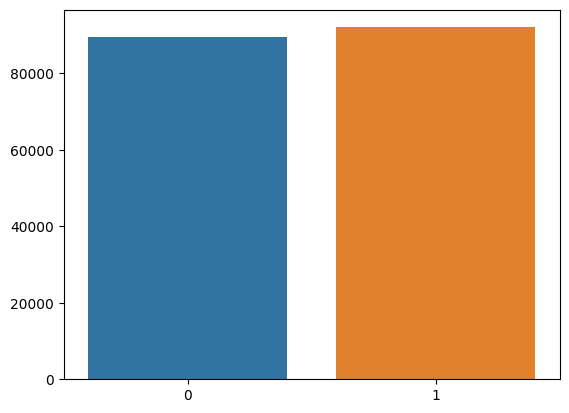

In [17]:
sns.barplot(x=df_train['class'].value_counts().index, y=df_train['class'].value_counts().values)

## 5 Перевод текста в нижний регистр

In [18]:
df_train['text'] = df_train.text.str.lower()
df_val['text'] = df_val.text.str.lower()

## 6 Определение классов Dataset и Model

### 6.1 Определение имени модели

In [19]:
name_of_model = "blanchefort/rubert-base-cased-sentiment-rusentiment"

In [20]:
class TwitterDataset(torch.utils.data.Dataset):

    def __init__(self, txts, labels):

        global name_of_model

        self._labels = labels

        self.tokenizer = BertTokenizer.from_pretrained(name_of_model)
        self._txts = [self.tokenizer(text, padding='max_length', max_length=10,
                                     truncation=True, return_tensors="pt")
                      for text in txts]

    def __len__(self):
        return len(self._txts)

    def __getitem__(self, index):
        return self._txts[index], self._labels[index]

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super().__init__()
        global name_of_model
        self.bert = BertModel.from_pretrained(name_of_model)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.sigm = nn.Sigmoid()

    def forward(self, x, mask):

        _, pooled_output = self.bert(input_ids=x, attention_mask=mask, return_dict=False)
        # _, pooled_output - набор эмбеддинигов слов, эмбеддинг предложения
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigm(linear_output)
        return final_layer

## 7 Запись данных в собственый класс(Dataset) и в Dataloader

In [26]:
y_train = df_train['class'].values
y_val = df_val['class'].values


In [27]:
train_dataset = TwitterDataset(df_train['text'], y_train)
valid_dataset = TwitterDataset(df_val['text'], y_val)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

## 8 Определение модели, функции потерь и оптимизатора

In [32]:
model = BertClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.linear.parameters(), lr=0.001)

## 9 Обучение модели

In [33]:
num_epochs = 10
train_acc = []
train_loss = []
val_acc = []
val_loss = []
start = time.time()
for epoch in range(num_epochs):
    total_acc_train = 0
    total_loss_train = 0

    model.train()
    for train_input, train_label in tqdm(train_loader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    model.eval()
    total_loss_val = 0
    total_acc_val = 0
    for val_input, val_label in valid_loader:
        mask_val = val_input['attention_mask'].to(device)
        input_id_val = val_input['input_ids'].squeeze(1).to(device)
        val_label = val_label.to(device)

        output = model(input_id_val, mask_val)

        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc

    print(f"Epochs {epoch + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
    | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
    | Val Loss: {total_loss_val / len(valid_dataset): .3f} \
    | Val Accuracy: {total_acc_val / len(valid_dataset): .3f}")
    train_acc.append(total_acc_train / len(train_dataset))
    train_loss.append(total_loss_train / len(train_dataset))
    val_acc.append(total_acc_val / len(valid_dataset))
    val_loss.append(total_loss_val / len(valid_dataset))

stop = time.time()
print(f"It is took {round(stop - start, 3)} sec.")

100%|██████████| 2836/2836 [04:56<00:00,  9.55it/s]


Epochs 1 | Train Loss:  0.010     | Train Accuracy:  0.641     | Val Loss:  0.010     | Val Accuracy:  0.640


100%|██████████| 2836/2836 [05:02<00:00,  9.38it/s]


Epochs 2 | Train Loss:  0.010     | Train Accuracy:  0.643     | Val Loss:  0.010     | Val Accuracy:  0.641


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 3 | Train Loss:  0.010     | Train Accuracy:  0.644     | Val Loss:  0.010     | Val Accuracy:  0.641


100%|██████████| 2836/2836 [05:00<00:00,  9.43it/s]


Epochs 4 | Train Loss:  0.010     | Train Accuracy:  0.643     | Val Loss:  0.010     | Val Accuracy:  0.642


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 5 | Train Loss:  0.010     | Train Accuracy:  0.644     | Val Loss:  0.010     | Val Accuracy:  0.643


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 6 | Train Loss:  0.010     | Train Accuracy:  0.643     | Val Loss:  0.010     | Val Accuracy:  0.642


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 7 | Train Loss:  0.010     | Train Accuracy:  0.643     | Val Loss:  0.010     | Val Accuracy:  0.642


100%|██████████| 2836/2836 [05:00<00:00,  9.45it/s]


Epochs 8 | Train Loss:  0.010     | Train Accuracy:  0.644     | Val Loss:  0.010     | Val Accuracy:  0.641


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 9 | Train Loss:  0.010     | Train Accuracy:  0.644     | Val Loss:  0.010     | Val Accuracy:  0.642


100%|██████████| 2836/2836 [05:00<00:00,  9.44it/s]


Epochs 10 | Train Loss:  0.010     | Train Accuracy:  0.644     | Val Loss:  0.010     | Val Accuracy:  0.643
It is took 3134.595 sec.


## 10 Графическое отображения результатов обучения модели

Text(0.5, 1.0, 'Loss')

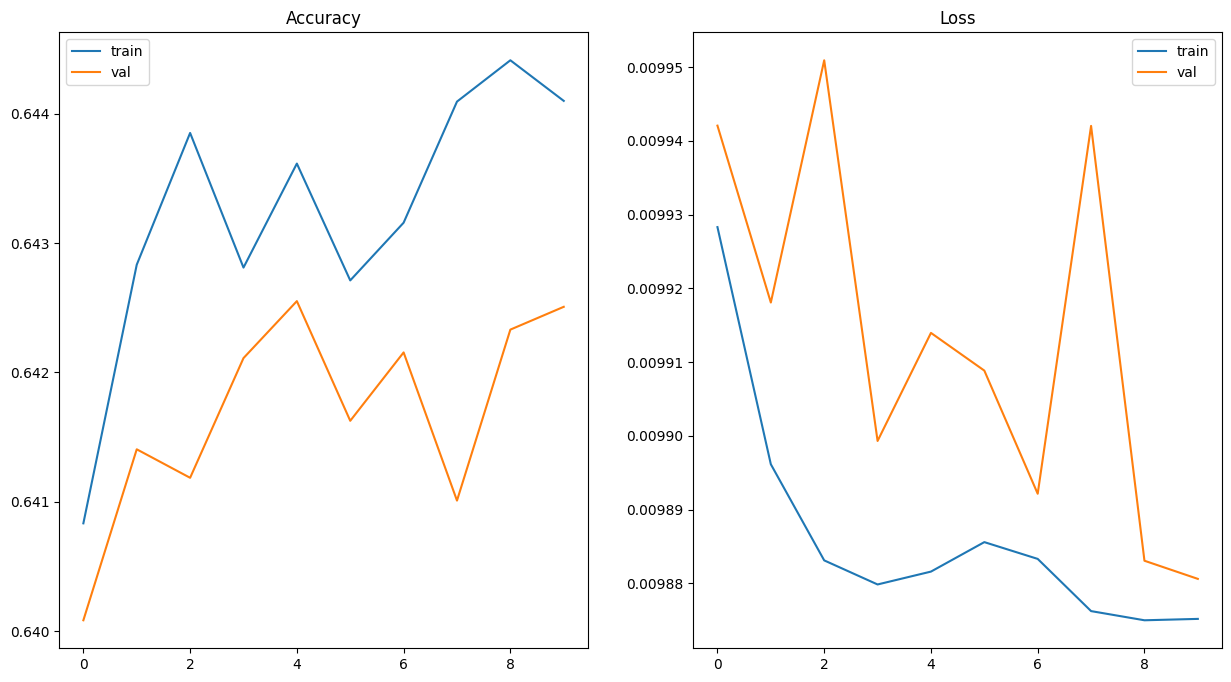

In [40]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
ax1.plot(train_acc)
ax1.plot(val_acc)
ax1.legend(["train", "val"])
ax1.set_title("Accuracy")
ax2 = plt.subplot(122)
ax2.plot(train_loss)
ax2.plot(val_loss)
ax2.legend(["train", "val"])
ax2.set_title("Loss")